## Effects of Wine Physico-chemical Properties and Their Ratings

### Investigation Overview

In this investigation, I wanted to look at physico-chemical propertoes of wines and how it affects their ratings. This rating is rated from 0-10 by the sensory test.

### Dataset Overview

The two datasets (white and red) are related to vairants of the Portuguese "Vinho Verde" wine.

In [48]:
#import all the required packages
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, r2_score
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, scale
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import explained_variance_score
from sklearn.cluster import KMeans

In [28]:
#import data
red_wine_data = pd.read_csv('winequality-red.csv', delimiter = ';')
white_wine_data = pd.read_csv('winequality-white.csv',delimiter = ';')

In [29]:
white_wine_data = white_wine_data.drop_duplicates()
red_wine_data = red_wine_data.drop_duplicates()

In [30]:
#join_data for red and white wine
red_wine_data['type'] = 'red'
white_wine_data['type'] = 'white'
join_data = pd.concat([red_wine_data,white_wine_data])

In [31]:
def label_data(xaxis, yaxis, title):
    '''
    label plot data and title with given xaxis,yaxis, and title string.
    '''
    y_label = plt.ylabel(yaxis)
    x_label = plt.xlabel(xaxis)
    title = plt.title(title)
    return y_label, x_label, title

def data_legend(color1, color2, label1, label2,legend_location):
    '''
    label data legend witht the given colors and labels string and the legend location
    '''
    color1_patch = mpatches.Patch(color = color1, label = label1)
    color2_patch = mpatches.Patch(color = color2, label = label2)
    return plt.legend(handles = [color1_patch, color2_patch], loc = legend_location)

### Distribution of Wine Quality Rating based on Type

White wine has more frequency in all quality score and it seems like the center of red wine data is closer to 5 and the white wine is closer to 6. However, the center between 5 and 6 is expected. The dataset contains mostly mediocre wine, which could make it hard to predict the lower and higher rated wine.The maximum score for white wine is 9 and red wine is 8.

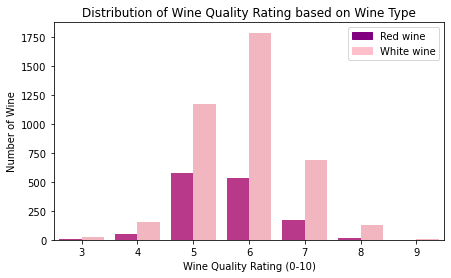

In [32]:
plt.figure(figsize = [7,4])
color = sb.set_palette(reversed(sb.color_palette("RdPu", 2)), 3)
sb.countplot(x = 'quality',data = join_data, hue='type', color = color)
label_data('Wine Quality Rating (0-10)','Number of Wine','Distribution of Wine Quality Rating based on Wine Type')
data_legend('purple', 'pink', 'Red wine','White wine', 1);

White wine is about 3 times more abundant than red.

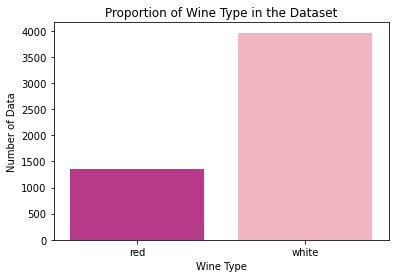

In [33]:
sb.countplot(x ='type', data = join_data)
label_data('Wine Type','Number of Data','Proportion of Wine Type in the Dataset') ;

From observing correlation matrix the top 3 correlated features are alcohol, density and volatile acidity. 

Free sulfure dioxide is correlated to total sulfur dioixde which is expected since total sulfure dioxide is the sulfur dioxide that is free in the wine plus the portion that is bound to other chemicals such as aldehydes, pigments, or sugars. SO2 helps protect the wine from the oxidation and spoilage. This is critical when SO2 is lost through aeration or binding. According to a paper from Iowa state, when a wine where free SO2 is unusally small percentage of the total SO2, this is an indication that there is something making the wine chemically or microbially unstable. Therefore, we will engineer another feature which is the proportion of Free SO2.

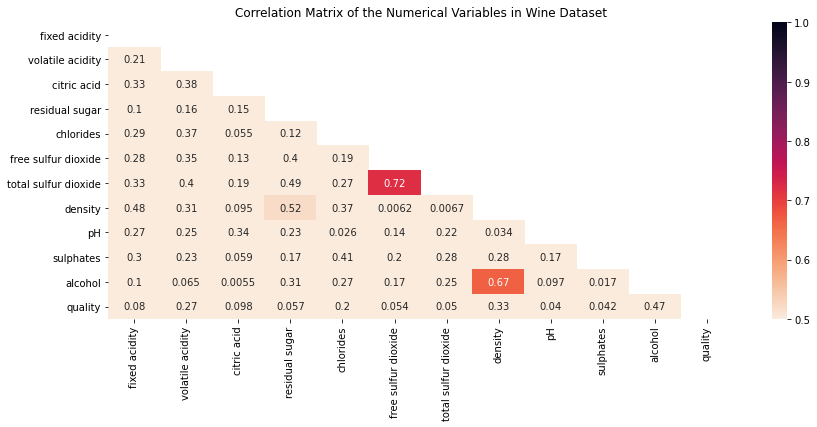

In [34]:
matrix = np.triu(join_data.corr())
plt.figure(figsize=[14,12])
plt.subplot(2,1,1)
sb.heatmap(join_data.corr().abs(), cmap= sb.cm.rocket_r, vmin=0.5, mask=matrix, annot=True)
plt.title('Correlation Matrix of the Numerical Variables in Wine Dataset');

In [35]:
join_data['free_SO2_proportion'] = join_data['free sulfur dioxide'] / join_data['total sulfur dioxide']

The scatterplot showed a slight increase in free SO2 proportion to wine quality until free SO2 proportion reaches 0.2.

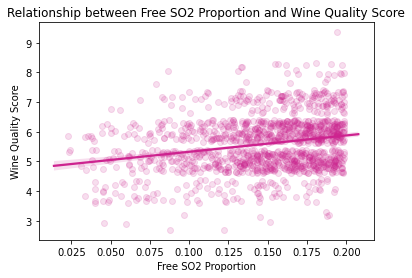

In [36]:
sb.regplot(x = 'free_SO2_proportion', y = 'quality', data = join_data.query('free_SO2_proportion < 0.20'), y_jitter=0.4, scatter_kws={'alpha':0.15})
plt.title('Relationship between Free SO2 Proportion and Wine Quality Score')
plt.ylabel('Wine Quality Score')
plt.xlabel('Free SO2 Proportion');

>Alcohol, density, free SO2 proportion, and chlorides seem to have correlation with the quality. Let's plot these boxplot with cateogry included to see any patterns. 

>Seems that the correlation between density and alcohol content stems from the same principle. Since more alcohol content contributes to lower wine density, this correlation is probably due to multicollinearity. On a side note, wine with higher alcohol content will have a fuller, richer body, while a lower alcohol wine will taste lighter and more delicate on the palete. This will contributes to different person has different preference and make it harder to predict the rating. However, in order to reduce confounding effect, density feature was removed.


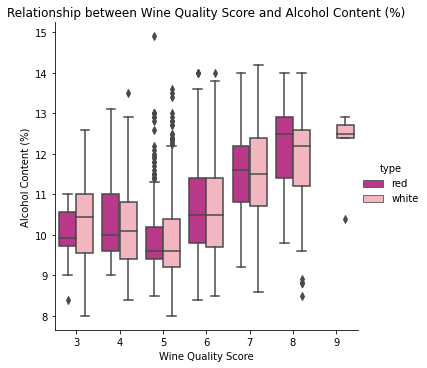

In [37]:
sb.catplot(x="quality", y="alcohol", hue="type", kind="box", data=join_data)
plt.title('Relationship between Wine Quality Score and Alcohol Content (%)')
plt.ylabel('Alcohol Content (%)')
plt.xlabel('Wine Quality Score');

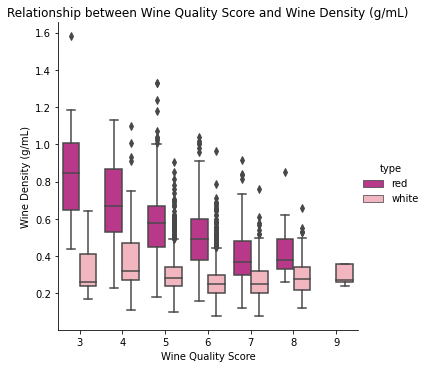

In [38]:
sb.catplot(x="quality", y="volatile acidity", hue="type", kind="box", data=join_data)
plt.title('Relationship between Wine Quality Score and Wine Density (g/mL)')
plt.ylabel('Wine Density (g/mL)')
plt.xlabel('Wine Quality Score');

In [39]:
quality_data_3_categories = []
for quality in join_data['quality']:
    if quality < 4:
        quality = "low"
    elif quality < 7:
        quality = "medium"
    else:
        quality = "high"
    quality_data_3_categories.append(quality)

quality_data_2_categories = ["high" if quality > 5 else "low" for quality in join_data['quality']]

join_data['rating_2_buckets'] = quality_data_2_categories
join_data['quality_3_categories'] = quality_data_3_categories

The darker the color is the higher the wine rating. We sees a slight trend that the highly rated alcohol tends to have around 13-14 % and volatile acidity between 0.3 and 0.6 g/ml.

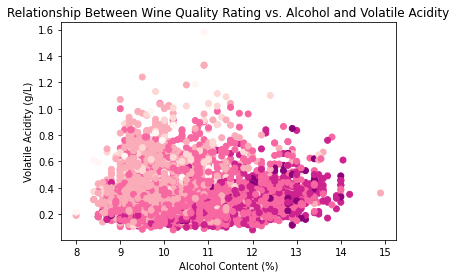

In [49]:
plt.scatter(x = 'alcohol', y = 'volatile acidity', c = 'quality',cmap = 'RdPu', data = join_data)
plt.xlabel('Alcohol Content (%)')
plt.ylabel('Volatile Acidity (g/L)')
plt.title('Relationship Between Wine Quality Rating vs. Alcohol and Volatile Acidity');

In [50]:
join_data['white_wine'] = pd.get_dummies(join_data,columns = ['type'],drop_first=True)['type_white']

In [51]:
X_col = [col  for col in join_data.columns if col not in ['quality','type', 'rating_2_buckets', 'quality_3_categories']]

X,y = join_data[X_col] ,pd.Series(join_data['quality'])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
tree_classifier = DecisionTreeRegressor( max_depth= 3, min_samples_split=25, random_state=42)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
tree_classifier = DecisionTreeRegressor( max_depth= 3, min_samples_split=25, random_state=42)

Using Dimensionality Reduction to see whether we can segregate the data further with 2 dimensions and it seems that our plot earlier with volatile acidity and alcohol seems to do similar job with plot after the features are being scaled and dimensionality reduced.

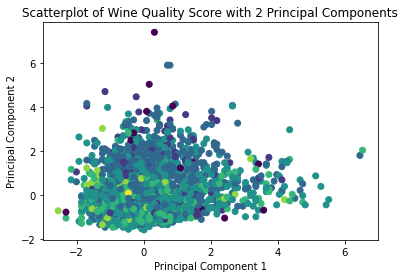

In [54]:
plt.scatter(PCA(scale(X_train)).n_components[:,0],PCA(scale(X_train)).n_components[:,1], c = y_train)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatterplot of Wine Quality Score with 2 Principal Components');

Decision Tree is plotted to visualize the deicions made by the algorithm and it seems that alcohol and volatile acidity seems to be the biggest factor for prediciting wine quality whether it is white or red. The feature importances is calculated and alcohol obtains 79% and volatile acidity obtains 12%.

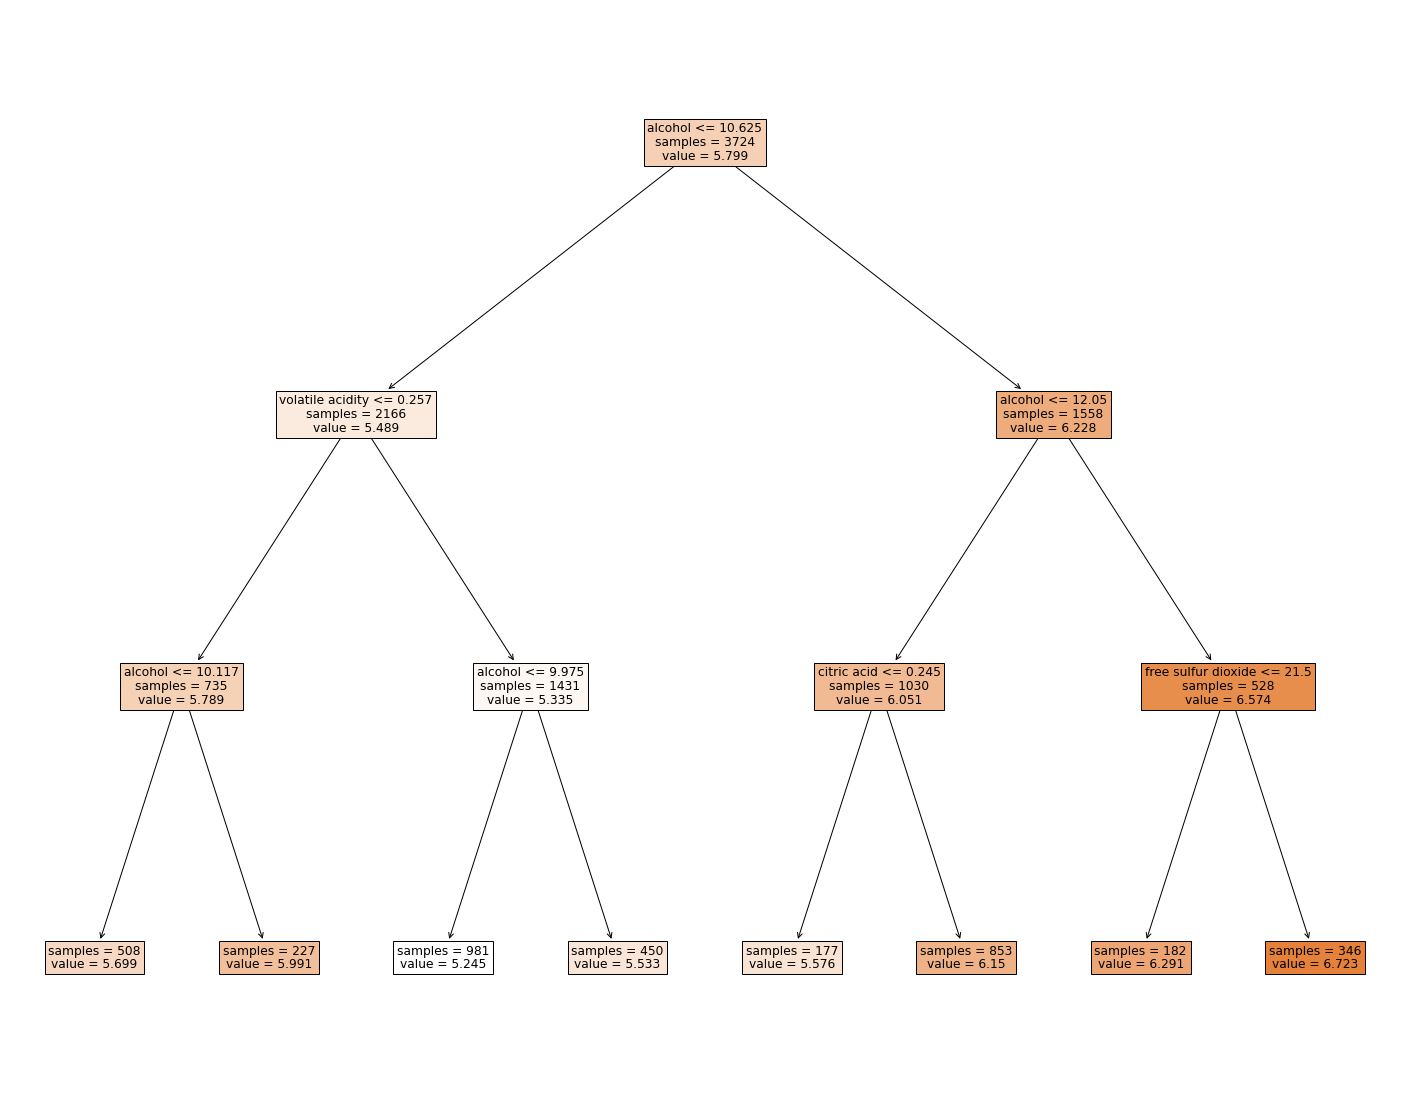

In [46]:
tree_classifier_fit = tree_classifier.fit(X_train, y_train)
y_pred = tree_classifier.predict(X_test)
r2_score(y_test, y_pred)

tree_classifier_fit.feature_importances_

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_classifier_fit, 
                   feature_names=X.columns,
                   impurity=False,
                   filled=True)

In [47]:
for i in range(len(tree_classifier_fit.feature_importances_)):
    print(X.columns[i],round(tree_classifier_fit.feature_importances_[i],2))

fixed acidity 0.0
volatile acidity 0.12
citric acid 0.06
residual sugar 0.0
chlorides 0.0
free sulfur dioxide 0.03
total sulfur dioxide 0.0
density 0.0
pH 0.0
sulphates 0.0
alcohol 0.79
free_SO2_proportion 0.0
white_wine 0.0
